# Modeling Protest Trends in South America
This notebook is modeling of the protest data for the South American region. The first section will focus primarily on predicting whether or not a protest received accomodations from the government leadership. This modeling will also look at what the protest outcomes ultimately were. While binary classification was assessed on all state response columns, meaning if accomodation was found in any column in a given row it was counted, multiclass models only assess one column of state responses. This is due to time and data constraints.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import classification as cl

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv('../data/mmALL_073119_csv.csv')
df.head(2)

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes
0,201990001,Canada,20,1990,North America,1,1,15.0,1.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. Great Canadian train journeys into history;...,Canada s railway passenger system was finally...
1,201990002,Canada,20,1990,North America,1,2,25.0,6.0,1990.0,...,NaN,ignore,NaN,NaN,NaN,NaN,NaN,NaN,1. Autonomy s Cry Revived in Quebec The New Yo...,protestors were only identified as young peop...


In [5]:
print(df.shape)

(16363, 31)


In [6]:
# Data engineering: length of protests
df['years'] = df['endyear'] - df['startyear']
df['months'] = df['endmonth'] - df['startmonth']
df['days'] = df['endday'] - df['startday']
df['total_days'] = df['days'] + (df['months']*30.5) + (df['years']*365)

In [7]:
categorical_columns = ['country', 'year', 'protest', 'protesterviolence',  'participants_category', 'protesterdemand1',
       'protesterdemand2', 'protesterdemand3', 'protesterdemand4', 'stateresponse1', 'stateresponse2', 'stateresponse3', 'stateresponse4','stateresponse5', 'stateresponse6', 'stateresponse7']
numerical_columns = ['startday', 'startmonth', 'startyear', 'endday', 'endmonth', 'endyear', 'years', 'total_days']

id_columns = ['id','sources','notes', 'protesteridentity', 'location']

In [8]:
for column in categorical_columns:
    df[column].fillna('999', inplace=True)
    df[column] = df[column].map(str)
for column in numerical_columns:
    df[column].fillna(999, inplace=True)

In [9]:
sa_df = df[df['region'] == 'South America'].copy()

In [10]:
sa_df = pd.get_dummies(sa_df, columns=['country', 'year', 'protest', 'protesterviolence',  'participants_category'], drop_first=True)

In [11]:
protest_demands = ['protesterdemand1','protesterdemand2', 'protesterdemand3', 'protesterdemand4']
sa_df = pd.get_dummies(sa_df, columns=protest_demands, prefix="dem", drop_first=True)
sa_df_total = cl.dummy_columns(sa_df)
print(sa_df_total.shape)

(1653, 108)


In [12]:
sa_df_total.head(2)

,id,ccode,region,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,...,dem_land farm issue,999,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings,.
1044,1001990001,100,South America,1,13.0,2.0,1990.0,13.0,2.0,1990.0,...,0,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1045,1001990002,100,South America,2,14.0,2.0,1990.0,15.0,2.0,1990.0,...,0,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


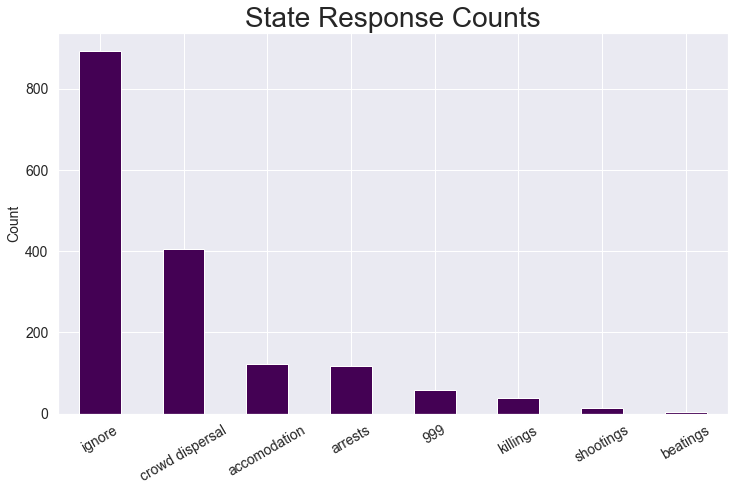

In [13]:
sns.set()
plt.figure(figsize=(12,7))
sa_df['stateresponse1'].value_counts().plot.bar(cmap='viridis', fontsize=14)
plt.xticks(rotation = 30)
plt.ylabel('Count', fontsize=14)
plt.title('State Response Counts', fontsize=28);

In [14]:
sa_df_total['accomodation'] = sa_df_total['accomodation'].map(lambda x: 1 if x>0 else 0)
sa_df_total['accomodation'].value_counts()

0    1474
1     179
Name: accomodation, dtype: int64

In [15]:
sa_df_total['accomodation'].value_counts(normalize=True)

0    0.891712
1    0.108288
Name: accomodation, dtype: float64

In [16]:
drop = ['id', 'ccode', 'region', 'startday',
       'endday', 'endmonth', 'location', 'participants', 'protesteridentity', 'stateresponse1', 'stateresponse2',
       'stateresponse3', 'stateresponse4', 'stateresponse5', 'stateresponse6',
       'stateresponse7', 'sources', 'notes', '.', '999',
       'accomodation', 'arrests', 'beatings', 'crowd dispersal', 'ignore',
       'killings', 'shootings','years','months','days']

X = sa_df_total.drop(columns = drop)
y = sa_df_total['accomodation']
X_train_sc, X_test_sc, y_train, y_test = cl.split_scale(X, y)

## Binary classification of accomodations in state response

In [17]:
logreg_bin = LogisticRegression()
cl.scoring_class(logreg_bin, X_train_sc, y_train, X_test_sc, y_test)

LogisticRegression() train score Accuracy: 0.9071832122679581
LogisticRegression() test score Accuracy: 0.8719806763285024


In [18]:
cl.con_mets(logreg_bin, X_test_sc, y_test)

Specificity: 0.9728997289972899
Sensitivity: 0.044444444444444446
Precision:   0.16666666666666666


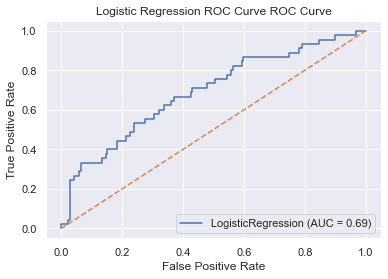

In [19]:
cl.roc_curve(logreg_bin, 'Logistic Regression ROC Curve', X_test_sc, y_test)

In [20]:
knn_bin = KNeighborsClassifier()
cl.scoring_class(knn_bin, X_train_sc, y_train, X_test_sc, y_test)
cl.con_mets(knn_bin, X_test_sc, y_test)

KNeighborsClassifier() train score Accuracy: 0.9063761097659403
KNeighborsClassifier() test score Accuracy: 0.8599033816425121
Specificity: 0.962059620596206
Sensitivity: 0.022222222222222223
Precision:   0.06666666666666667


In [21]:
dt_bin = DecisionTreeClassifier()
cl.scoring_class(dt_bin, X_train_sc, y_train, X_test_sc, y_test)
cl.con_mets(dt_bin, X_test_sc, y_test)

DecisionTreeClassifier() train score Accuracy: 1.0
DecisionTreeClassifier() test score Accuracy: 0.857487922705314
Specificity: 0.924119241192412
Sensitivity: 0.3111111111111111
Precision:   0.3333333333333333


In [22]:
rf_bin = RandomForestClassifier()
cl.scoring_class(rf_bin, X_train_sc, y_train, X_test_sc, y_test)
cl.con_mets(rf_bin, X_test_sc, y_test)

RandomForestClassifier() train score Accuracy: 1.0
RandomForestClassifier() test score Accuracy: 0.8913043478260869
Specificity: 0.978319783197832
Sensitivity: 0.17777777777777778
Precision:   0.5


In [23]:
bdt_bin = BaggingClassifier()
cl.scoring_class(bdt_bin, X_train_sc, y_train, X_test_sc, y_test)
cl.con_mets(bdt_bin, X_test_sc, y_test)

BaggingClassifier() train score Accuracy: 0.9903147699757869
BaggingClassifier() test score Accuracy: 0.8768115942028986
Specificity: 0.959349593495935
Sensitivity: 0.2
Precision:   0.375


In [24]:
ada_bin = AdaBoostClassifier()
cl.scoring_class(ada_bin, X_train_sc, y_train, X_test_sc, y_test)
cl.con_mets(ada_bin, X_test_sc, y_test)

AdaBoostClassifier() train score Accuracy: 0.9128329297820823
AdaBoostClassifier() test score Accuracy: 0.8743961352657005
Specificity: 0.948509485094851
Sensitivity: 0.26666666666666666
Precision:   0.3870967741935484


In [25]:
svm_bin = SVC()
cl.scoring_class(svm_bin, X_train_sc, y_train, X_test_sc, y_test)
cl.con_mets(svm_bin, X_test_sc, y_test)

SVC() train score Accuracy: 0.9023405972558515
SVC() test score Accuracy: 0.8913043478260869
Specificity: 1.0
Sensitivity: 0.0
Precision:   nan


/Users/jenniferwilliamson/DSI/projects/Group_Project_Boo-Leans/code/classification.py:69: RuntimeWarning: invalid value encountered in long_scalars
  print(f'Precision:   {tp / (tp + fp)}')


Almost all of the models above are overfit except K Nearest Neighbors and Support Vector Machine. Additionally, None of them have an improvement over baseline in predicting accomodations. Furthermore in most cases the model seems to have similar scores to baseline because the models tend to over predict "no accomodations." 

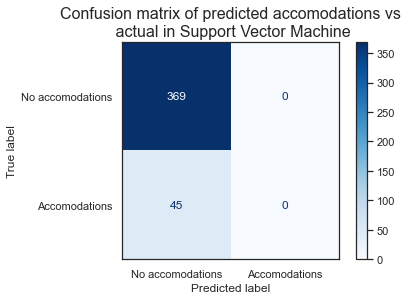

In [26]:
cl.con_plot(svm_bin, X_test_sc, y_test, 'Support Vector Machine')

In [27]:
pipe_ada = Pipeline([
    ('pc',PCA()),
    ('model',AdaBoostClassifier())
])
ada_params = {'pc__n_components':[10,15,20],
              'model__n_estimators':[40,50,60],
             'model__learning_rate':[0.5,1,1.5]}
ada_grid_bin = GridSearchCV(pipe_ada,
                     ada_params,
                     cv=5,
                     verbose=1)
ada_grid_bin.fit(X_train_sc, y_train)
print(ada_grid_bin.best_params_)
print(ada_grid_bin.best_score_)
print(ada_grid_bin.score(X_test_sc, y_test))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   44.0s finished


{'model__learning_rate': 0.5, 'model__n_estimators': 60, 'pc__n_components': 10}
0.8926635758129816
0.8792270531400966


In [28]:
pipe_bag = Pipeline([
    ('pc',PCA()),
    ('model',SVC())
])
svc_params = {'pc__n_components':[10,15,20],
              'model__C':[0.01,0.05],
             'model__degree':[3,4,5]}
svc_grid_bin = GridSearchCV(pipe_bag,
                     svc_params,
                     cv=5,
                     verbose=1)
svc_grid_bin.fit(X_train_sc, y_train)
print(svc_grid_bin.best_params_)
print(svc_grid_bin.best_score_)
print(svc_grid_bin.score(X_test_sc, y_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'model__C': 0.01, 'model__degree': 3, 'pc__n_components': 10}
0.8918505942275041
0.8913043478260869


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    3.9s finished


In [29]:
cl.con_mets(svc_grid_bin, X_test_sc, y_test)

Specificity: 1.0
Sensitivity: 0.0
Precision:   nan


/Users/jenniferwilliamson/DSI/projects/Group_Project_Boo-Leans/code/classification.py:69: RuntimeWarning: invalid value encountered in long_scalars
  print(f'Precision:   {tp / (tp + fp)}')


Grid searching over these models improved adaboost slightly but overall the socre is not improved over baseline.

## Multiclass classification of state response

In [30]:
y_m = sa_df['stateresponse1']
y_m.value_counts()

ignore             892
crowd dispersal    405
accomodation       123
arrests            118
999                 58
killings            39
shootings           14
beatings             4
Name: stateresponse1, dtype: int64

In [31]:
#Combine the 3 most violent categories as there seems to be little difference
y_m = y_m.map(str)
y_m = y_m.map({'ignore': 0, 'crowd dispersal': 1, 'accomodation': 2, 'arrests': 3, 'killings': 4, 'shootings': 4, 'beatings': 4, '999': 999})
y_m.value_counts()

0      892
1      405
2      123
3      118
999     58
4       57
Name: stateresponse1, dtype: int64

In [32]:
X_train_sc, X_test_sc, y_train_m, y_test_m = cl.split_scale(X, y_m)

In [33]:
logreg_m = LogisticRegression()
cl.scoring_class(logreg_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

LogisticRegression() train score Accuracy: 0.7134786117836965
LogisticRegression() test score Accuracy: 0.6521739130434783


/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
knn_m = KNeighborsClassifier()
cl.scoring_class(knn_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

KNeighborsClassifier() train score Accuracy: 0.7021791767554479
KNeighborsClassifier() test score Accuracy: 0.5676328502415459


In [35]:
svm_m = SVC()
cl.scoring_class(svm_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

SVC() train score Accuracy: 0.7376916868442293
SVC() test score Accuracy: 0.6521739130434783


In [36]:
dt_m = DecisionTreeClassifier()
cl.scoring_class(dt_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

DecisionTreeClassifier() train score Accuracy: 1.0
DecisionTreeClassifier() test score Accuracy: 0.5748792270531401


In [37]:
bdt_m = BaggingClassifier()
cl.scoring_class(bdt_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

BaggingClassifier() train score Accuracy: 0.9725585149313963
BaggingClassifier() test score Accuracy: 0.642512077294686


In [38]:
rf_m = RandomForestClassifier()
cl.scoring_class(rf_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

RandomForestClassifier() train score Accuracy: 1.0
RandomForestClassifier() test score Accuracy: 0.6521739130434783


In [39]:
ada_m = AdaBoostClassifier()
cl.scoring_class(ada_m, X_train_sc, y_train_m, X_test_sc, y_test_m)

AdaBoostClassifier() train score Accuracy: 0.483454398708636
AdaBoostClassifier() test score Accuracy: 0.5265700483091788


While many of these models are much worse that the binary classification however Logistic regression was able to get a better accuracy than baseline and many of the others show some promise given some regulation.

In [40]:
pipe_bag = Pipeline([
    ('pc',PCA()),
    ('model',SVC())
])
svc_params = {'pc__n_components':[10,15,20],
              'model__C':[0.01,0.05],
             'model__degree':[3,4,5]}
svc_grid_bin = GridSearchCV(pipe_bag,
                     svc_params,
                     cv=5,
                     verbose=1)
svc_grid_bin.fit(X_train_sc, y_train_m)
print(svc_grid_bin.best_params_)
print(svc_grid_bin.best_score_)
print(svc_grid_bin.score(X_test_sc, y_test_m))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'model__C': 0.05, 'model__degree': 4, 'pc__n_components': 10}
0.5536763745592268
0.5531400966183575


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    8.6s finished
